In [2]:
import copy
import csv
import importlib
import logging
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypsa
import seaborn as sns

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

In [3]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name + "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)


def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    import pandas as pd
    
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")


def set_uniform_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''

    Parameters
    ----------
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"] 
    '''

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
          
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                ## special cases
                if datatype == "generators-p_max_pu":
                    # add a ridiculous amount of generation so the is always enough power and sim doesn't fail
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=100, high=200, size=n_samples)
                elif datatype == "snapshots":
                    addon[column] = np.ones(n_samples)
                else:
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=0, high=0.5, size=n_samples)
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][0])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(1).append(addon_dataframe)

    for datatype in data:
        data[datatype] = increase_data(data[datatype], n_samples-1, seed) # -1 is for original sample, which stays
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))


def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    from pathlib import Path
    import shutil
    
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/"  # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_gaussian_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")


def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import errno
    import os
    import shutil

    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Backup was not successful. Directory not copied. Error: %s' % e)



def add_mean_and_std_rows(dataframe):
    mean = dataframe.mean()
    std = dataframe.std()
    dataframe.loc["mean"] = mean
    dataframe.loc["std"] = std
    return dataframe


def maxae(y, y_pred, **kwargs):
    import numpy as np
    return max(np.abs(y-y_pred).ravel())

def rmse(y, y_pred, **kwargs):
    import operator
    return np.sqrt(np.mean(np.square(list(map(operator.sub, y, y_pred)))))

def set_data_size(features, labels, n_samples, n_training_samples):
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val, train_idx, test_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)

    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val, test_idx, train_idx

# Source Data

In [4]:
## USER INPUT
sample_size = 100000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example + "/ieee-13-with-load-gen-uniform-data-" +
                          str(sample_size) + "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [5]:
## Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
# else:
#     create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

# Analyse Data

In [6]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1)
features_and_labels = features.join(labels)

In [8]:
features.corr()

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611
load-632,1.000000,-0.001528,-0.006958,0.004319,0.000194,-0.002978,-0.006033,0.000107,0.004752
load-634,-0.001528,1.000000,0.001134,0.002052,0.000274,0.001524,-0.005657,0.004516,-0.000373
load-645,-0.006958,0.001134,1.000000,-0.002062,-0.005810,-0.001377,-0.006436,-0.000056,0.001200
load-646,0.004319,0.002052,-0.002062,1.000000,0.006828,0.001334,0.000946,0.002015,0.001021
load-652,0.000194,0.000274,-0.005810,0.006828,1.000000,-0.003613,-0.000496,-0.002886,-0.002240
load-671,-0.002978,0.001524,-0.001377,0.001334,-0.003613,1.000000,-0.005933,0.004243,0.000567
load-675,-0.006033,-0.005657,-0.006436,0.000946,-0.000496,-0.005933,1.000000,-0.001997,-0.001989
load-692,0.000107,0.004516,-0.000056,0.002015,-0.002886,0.004243,-0.001997,1.000000,0.000548
load-611,0.004752,-0.000373,0.001200,0.001021,-0.002240,0.000567,-0.001989,0.000548,1.000000


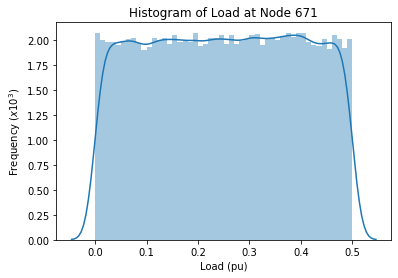

In [28]:
sns.distplot(features["load-671"], bins=50)
plt.xlabel("Load (pu)")
plt.ylabel("Frequency ($x10^3$)")
plt.title("Histogram of Load at Node 671")
# plt.savefig("uniform-samples-1e5-input-histogram.pdf")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00d25724d0>,
      dtype=object)

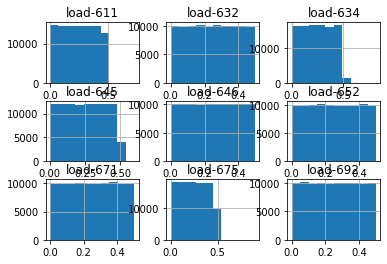

In [6]:
features.hist()

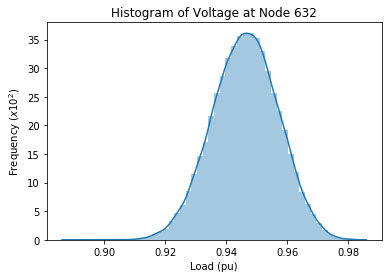

In [27]:
sns.distplot(labels["vmag-671"], bins=50)
plt.xlabel("Load (pu)")
plt.ylabel("Frequency ($x10^2$)")
plt.title("Histogram of Voltage at Node 671")
# plt.savefig("uniform-samples-1e5-voltage-histogram.pdf")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00d2566050>,
      dtype=object)

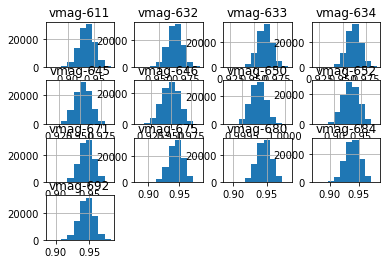

In [7]:
labels.hist()

In [28]:
def correlation_plot(corr_type):
    corr_matrix = labels.join(features).corr(method=corr_type)

    # only loads for columns
    cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
    reduced_corr_matrix = corr_matrix[cols]
    reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
    # only voltages for rows
    rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
    rows = rows.append(pd.Index(["vmag-650"]))
    reduced_corr_matrix.drop(rows, inplace=True)
    reduced_corr_matrix = reduced_corr_matrix.sort_index(axis=0, ascending=True)
    reduced_corr_matrix = reduced_corr_matrix.sort_index(axis=1, ascending=True)
    reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

    print(corr_type + " correlation")
    display(reduced_corr_matrix)
    
correlation_plot("pearson")
correlation_plot("kendall")
correlation_plot("spearman")

pearson correlation


,load-611,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,row average
vmag-611,-0.600170,-0.157880,-0.158084,-0.155850,-0.168281,-0.463138,-0.316864,-0.313902,-0.320260,-0.294936
vmag-632,-0.339914,-0.316812,-0.320804,-0.319882,-0.333944,-0.339195,-0.329811,-0.324215,-0.334387,-0.328774
vmag-633,-0.307554,-0.286406,-0.512513,-0.289868,-0.302645,-0.307178,-0.298881,-0.292050,-0.303695,-0.322310
vmag-634,-0.307463,-0.286326,-0.512387,-0.289801,-0.302548,-0.307111,-0.298800,-0.291940,-0.303616,-0.322221
vmag-645,-0.236599,-0.219407,-0.223990,-0.546822,-0.558979,-0.235927,-0.229190,-0.223332,-0.233060,-0.300812
vmag-646,-0.211118,-0.196512,-0.200144,-0.487273,-0.671172,-0.211606,-0.204674,-0.199273,-0.208235,-0.287779
vmag-652,-0.411965,-0.140446,-0.141170,-0.137119,-0.151906,-0.698675,-0.281787,-0.280290,-0.284874,-0.280915
vmag-671,-0.410221,-0.196724,-0.199334,-0.196651,-0.210183,-0.410146,-0.399117,-0.395772,-0.403272,-0.313491
vmag-675,-0.391644,-0.187323,-0.189802,-0.187164,-0.200840,-0.391617,-0.380550,-0.479096,-0.385147,-0.310354
vmag-680,-0.410221,-0.196724,-0.199334,-0.196651,-0.210183,-0.410146,-0.399117,-0.395772,-0.403272,-0.313491


kendall correlation


,load-611,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,row average
vmag-611,-0.418915,-0.101663,-0.101925,-0.100801,-0.108573,-0.310191,-0.207487,-0.204802,-0.209649,-0.196001
vmag-632,-0.225165,-0.209187,-0.211844,-0.211113,-0.221011,-0.224260,-0.218659,-0.213813,-0.221163,-0.217357
vmag-633,-0.202189,-0.187970,-0.350703,-0.189924,-0.198975,-0.201751,-0.196859,-0.191318,-0.199553,-0.213249
vmag-634,-0.202132,-0.187911,-0.350609,-0.189880,-0.198911,-0.201704,-0.196807,-0.191253,-0.199497,-0.213189
vmag-645,-0.153663,-0.142021,-0.144803,-0.374564,-0.384874,-0.152858,-0.148606,-0.144363,-0.150970,-0.199636
vmag-646,-0.135955,-0.126235,-0.128482,-0.325968,-0.478767,-0.136036,-0.131657,-0.127929,-0.133876,-0.191656
vmag-652,-0.270970,-0.089472,-0.090304,-0.087789,-0.097189,-0.504015,-0.182039,-0.180578,-0.184231,-0.187399
vmag-671,-0.274035,-0.127844,-0.129612,-0.128017,-0.136771,-0.273580,-0.266626,-0.263358,-0.269207,-0.207672
vmag-675,-0.260432,-0.121639,-0.123171,-0.121560,-0.130461,-0.260127,-0.253222,-0.324284,-0.256008,-0.205656
vmag-680,-0.274035,-0.127844,-0.129612,-0.128017,-0.136771,-0.273580,-0.266626,-0.263358,-0.269207,-0.207672


spearman correlation


,load-611,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,row average
vmag-611,-0.599975,-0.152183,-0.152486,-0.150733,-0.162515,-0.454350,-0.308096,-0.304107,-0.311351,-0.288422
vmag-632,-0.333668,-0.310644,-0.314368,-0.312889,-0.327820,-0.332274,-0.324281,-0.317129,-0.327903,-0.322331
vmag-633,-0.300407,-0.279735,-0.509819,-0.282067,-0.295777,-0.299658,-0.292581,-0.284499,-0.296573,-0.315680
vmag-634,-0.300325,-0.279648,-0.509691,-0.282004,-0.295685,-0.299590,-0.292503,-0.284404,-0.296493,-0.315594
vmag-645,-0.229277,-0.212127,-0.216167,-0.541762,-0.555955,-0.228088,-0.221887,-0.215420,-0.225178,-0.293985
vmag-646,-0.203133,-0.188719,-0.191986,-0.476240,-0.674466,-0.203230,-0.196797,-0.191097,-0.199904,-0.280619
vmag-652,-0.399375,-0.134038,-0.135227,-0.131385,-0.145550,-0.704010,-0.270975,-0.268766,-0.274249,-0.273730
vmag-671,-0.403574,-0.191122,-0.193688,-0.191095,-0.204399,-0.402782,-0.393045,-0.388250,-0.396823,-0.307198
vmag-675,-0.384339,-0.181889,-0.184154,-0.181551,-0.195038,-0.383648,-0.374022,-0.473606,-0.378044,-0.304032
vmag-680,-0.403574,-0.191122,-0.193688,-0.191095,-0.204399,-0.402782,-0.393045,-0.388250,-0.396823,-0.307198


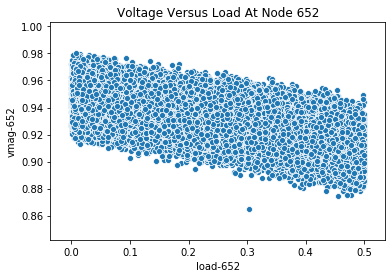

In [13]:
# data spread
sns.scatterplot(features["load-652"], labels["vmag-652"])
plt.title("Voltage Versus Load At Node 652")
# plt.savefig("scatter_652.pdf")
plt.show()

In [27]:
# test dimensionality reduction
from sklearn.ensemble import RandomForestRegressor

# first determine how many features to drop
import eli5
X_train, y_train, X_test, y_test, _, _ = set_data_size(features, labels, 1000, 800)
regression_model = RandomForestRegressor(n_estimators=100, max_depth=None)
regression_model.fit(X_train, y_train)
perm = eli5.sklearn.PermutationImportance(regression_model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
0.4260 ± 0.0289,x4
0.3229 ± 0.0172,x8
0.1784 ± 0.0196,x6
0.1655 ± 0.0111,x7
0.1521 ± 0.0113,x5
0.1176 ± 0.0056,x3
0.0851 ± 0.0061,x2
0.0453 ± 0.0040,x1
0.0280 ± 0.0018,x0
